In [1]:
import torch
import sklearn
import numpy as np
import glob
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import random
import sys
import seaborn as sns
import os

In [2]:
# Clone the repository
!git clone https://github.com/Shahin-96/MRI-Tumor-Detection-using-CNN.git

Cloning into 'MRI-Tumor-Detection-using-CNN'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 242 (delta 4), reused 235 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (242/242), 7.29 MiB | 10.96 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [3]:
def duplicate_handling(folder_path):
    file_tracker = {}  # Dictionary to track file counts

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        base_name, ext = os.path.splitext(file)

        # Track the original file name
        if base_name in file_tracker:
            counter = file_tracker[base_name] + 1
            new_file_name = f"{base_name}_{counter}{ext}"

            # Ensure no overwriting
            while os.path.exists(os.path.join(folder_path, new_file_name)):
                counter += 1
                new_file_name = f"{base_name}_{counter}{ext}"

            os.rename(file_path, os.path.join(folder_path, new_file_name))
            print(f"Renamed: {file} -> {new_file_name}")

            file_tracker[base_name] = counter  # Update the counter
        else:
            file_tracker[base_name] = 1  # First occurrence


In [4]:
def change_extension(file_path, new_extension):
    if not os.path.exists(file_path):
        print(f"Error: {file_path} not found.")
        return

    base_name, _ = os.path.splitext(file_path)
    new_file_path = base_name + "." + new_extension
    os.rename(file_path, new_file_path)
    # print(f"Renamed: {file_path} -> {new_file_path}")


In [5]:
path_yes = "/content/MRI-Tumor-Detection-using-CNN/brain_tumor_dataset/yes"
path_no = "/content/MRI-Tumor-Detection-using-CNN/brain_tumor_dataset/no"
duplicate_handling(path_yes)

# Step 2: Change all file extensions to JPG
for file in os.listdir(path_yes):
    file_path = os.path.join(path_yes, file)
    change_extension(file_path, "jpg")

Renamed: Y92.jpg -> Y92_2.jpg


In [6]:
# READing tumor images
tumor = []
path_yes = "/content/MRI-Tumor-Detection-using-CNN/brain_tumor_dataset/yes/*.jpg"
for file in glob.iglob(path_yes):
    img_tumor = cv2.imread(file)
    img_tumor = cv2.resize(img_tumor, (128, 128))
    b, g, r = cv2.split(img_tumor)
    img_tumor = cv2.merge((r,g,b))
    tumor.append(img_tumor)

In [7]:
# READing healthy images
healthy = []
path_no = "/content/MRI-Tumor-Detection-using-CNN/brain_tumor_dataset/no/*.jpg"
for file in glob.iglob(path_no):
    img_healthy = cv2.imread(file)
    img_healthy = cv2.resize(img_healthy, (128, 128))
    b, g, r = cv2.split(img_healthy)
    img_healthy = cv2.merge((r,g,b))
    healthy.append(img_healthy)

In [8]:
# Changing lists to arrays
tumor = np.array(tumor)
print(tumor.shape)
healthy = np.array(healthy)
print(healthy.shape)

(155, 128, 128, 3)
(98, 128, 128, 3)


In [9]:
def plot_random (tumor, healthy, num = 5):
    # random.choice(a, size=None, replace=True, p=None)
    tumor_images = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    healthy_images = healthy[np.random.choice(healthy.shape[0], num, replace=False)]

    plt.figure(figsize=(16, 9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title(f"Tumor no. {i+1}")
        plt.imshow(tumor_images[i])

    plt.figure(figsize=(16, 9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title(f"Healthy no. {i+1}")
        plt.imshow(healthy_images[i])

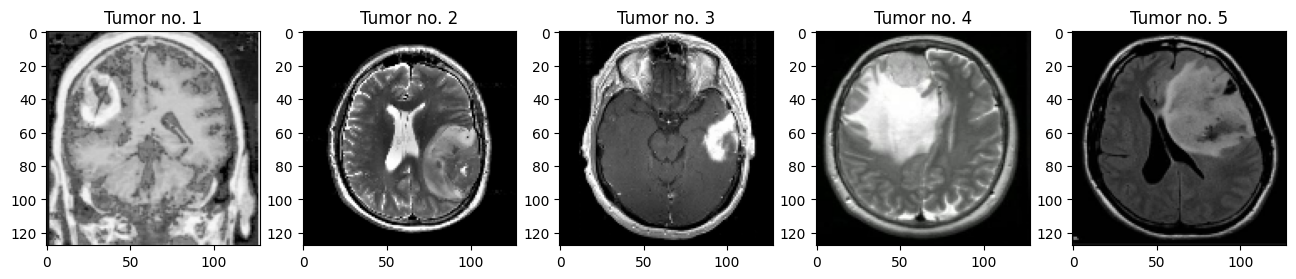

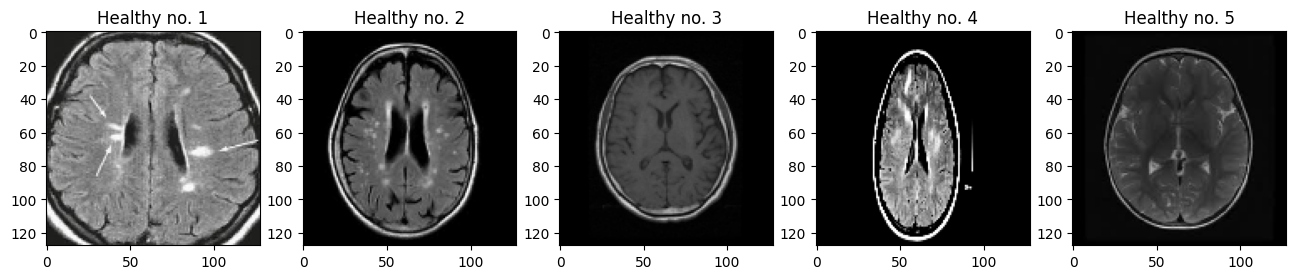

In [10]:
plot_random(tumor, healthy)

In [11]:
class MRI():
    def __init__(self):

        # READing All images
        tumor = []
        healthy = []
        path_yes = "/content/MRI-Tumor-Detection-using-CNN/brain_tumor_dataset/yes/*.jpg"
        for file in glob.iglob(path_yes):
            img_tumor = cv2.imread(file)
            img_tumor = cv2.resize(img_tumor, (128, 128))
            b, g, r = cv2.split(img_tumor)
            img_tumor = cv2.merge((r,g,b))
            img_tumor = img_tumor.reshape((img_tumor.shape[2], img_tumor.shape[0], img_tumor.shape[1]))
            tumor.append(img_tumor)
        path_no = "/content/MRI-Tumor-Detection-using-CNN/brain_tumor_dataset/no/*.jpg"
        for file in glob.iglob(path_no):
            img_healthy = cv2.imread(file)
            img_healthy = cv2.resize(img_healthy, (128, 128))
            b, g, r = cv2.split(img_healthy)
            img_healthy = cv2.merge((r,g,b))
            img_healthy = img_healthy.reshape((img_healthy.shape[2], img_healthy.shape[0], img_healthy.shape[1]))
            healthy.append(img_healthy)

        # Our images:
        tumor = np.array(tumor, dtype=np.float32)
        print(tumor.shape)
        healthy = np.array(healthy, dtype=np.float32)
        print(healthy.shape)


        # Our labels:
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # Concatenating tumor and healthy images and lables
        self.images = np.concatenate((tumor, healthy), axis = 0)
        #print(self.images.shape)
        self.labels = np.concatenate((tumor_label, healthy_label))
        #print(self.labels)

    def __getitem__(self, index):
        sample = {"image": self.images[index], "label": self.labels[index]}
        return sample

    def __len__(self):
        return self.images.shape[0]

    def normalize(self):
        self.images = self.images/255

In [12]:
mri = MRI()
mri.normalize()

(155, 3, 128, 128)
(98, 3, 128, 128)


In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size = 2, stride = 5),
        nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size = 2, stride = 5)
        )

        self.fc_model = nn.Sequential(
        nn.Linear(in_features = 256, out_features = 120),
        nn.Tanh(),
        nn.Linear(in_features = 120, out_features = 84),
        nn.Tanh(),
        nn.Linear(in_features = 84, out_features = 1),
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1) # This line will faltten the 2D arrays
        x = self.fc_model(x)
        x = torch.sigmoid(x)
        return x

In [15]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda')
model = CNN().to(device)

(155, 3, 128, 128)
(98, 3, 128, 128)


In [16]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [17]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())


In [18]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()


In [19]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x


In [20]:
print(f'The accuracy score is: {accuracy_score(y_true, threshold(outputs))}')

The accuracy score is: 0.38735177865612647


[Text(0, 0.5, 'Healthy'), Text(0, 1.5, 'Tumor')]

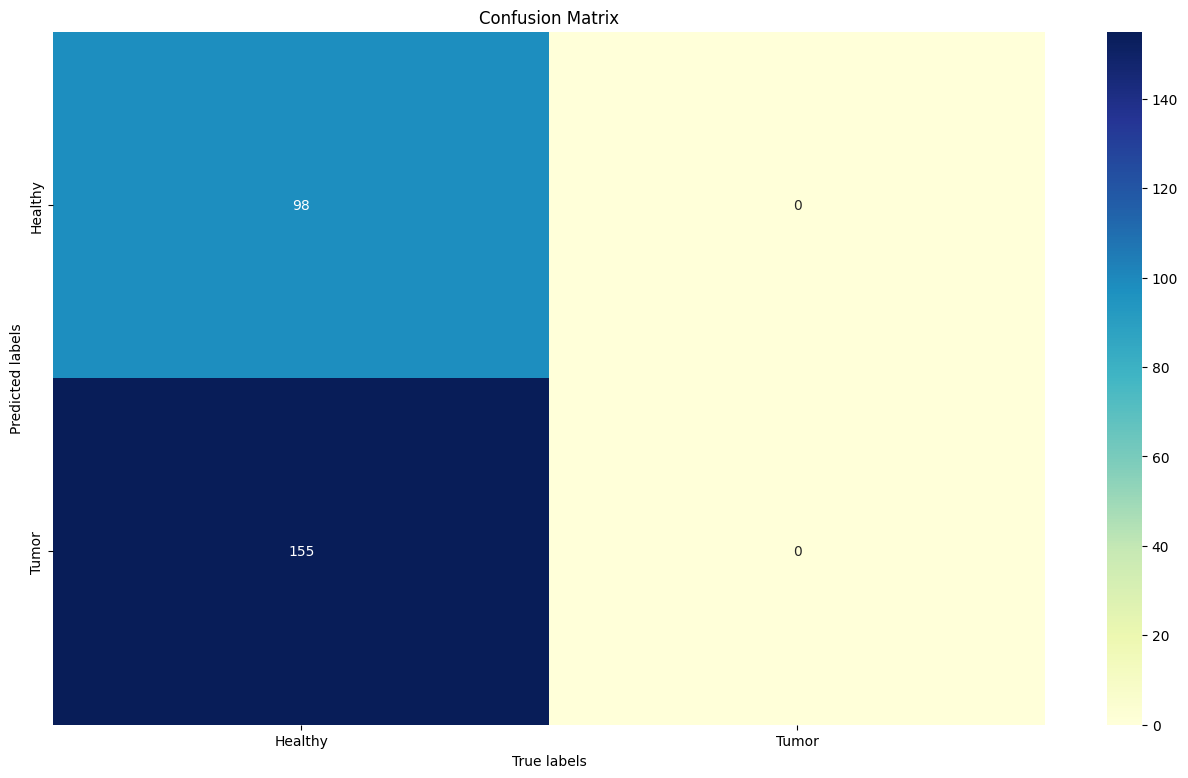

In [21]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
# seaborn.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g',
# annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False,
# xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)
sns.heatmap(cm, annot=True, fmt = 'g', ax=ax, cmap="YlGnBu");  #annot=True to annotate cells, fmt='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('True labels');
ax.set_ylabel('Predicted labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Healthy','Tumor'])
ax.yaxis.set_ticklabels(['Healthy','Tumor'])

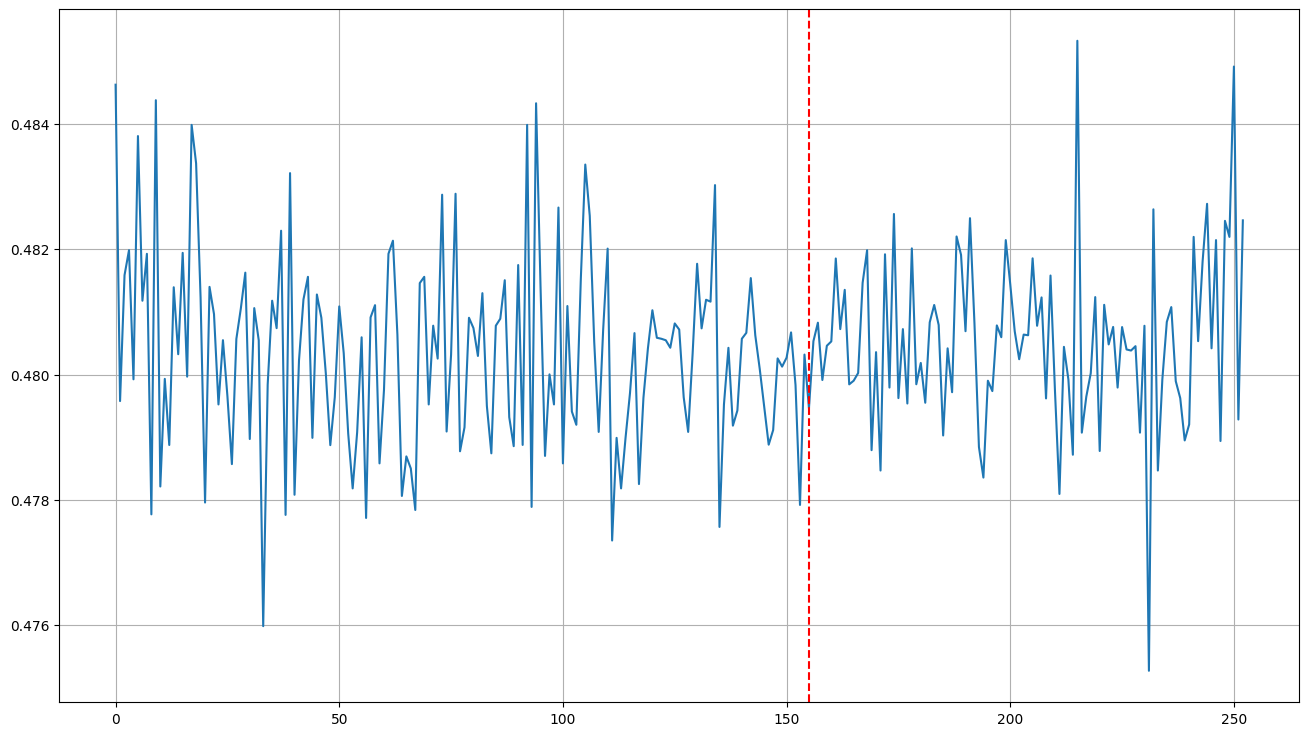

In [22]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [23]:
eta = 0.001
EPOCH = 100
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [24]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.510529
Train Epoch: 20	Loss: 0.309466
Train Epoch: 30	Loss: 0.146415
Train Epoch: 40	Loss: 0.065436
Train Epoch: 50	Loss: 0.003866
Train Epoch: 60	Loss: 0.001839
Train Epoch: 70	Loss: 0.001170
Train Epoch: 80	Loss: 0.000823
Train Epoch: 90	Loss: 0.000614
Train Epoch: 100	Loss: 0.000464


In [25]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())


outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [26]:
print(f'The accuracy score is: {accuracy_score(y_true, threshold(outputs))}')

The accuracy score is: 1.0


[Text(0, 0.5, 'Healthy'), Text(0, 1.5, 'Tumor')]

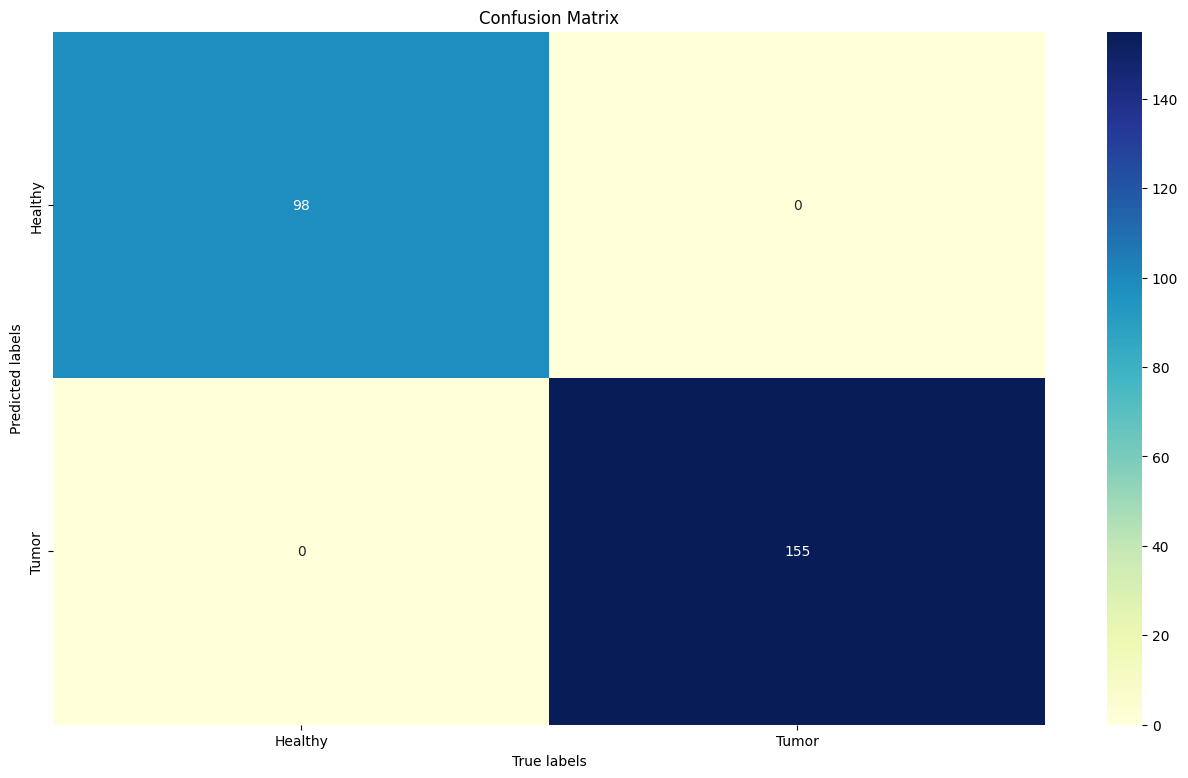

In [27]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt = 'g', ax=ax, cmap="YlGnBu");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('True labels');
ax.set_ylabel('Predicted labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Healthy','Tumor'])
ax.yaxis.set_ticklabels(['Healthy','Tumor'])

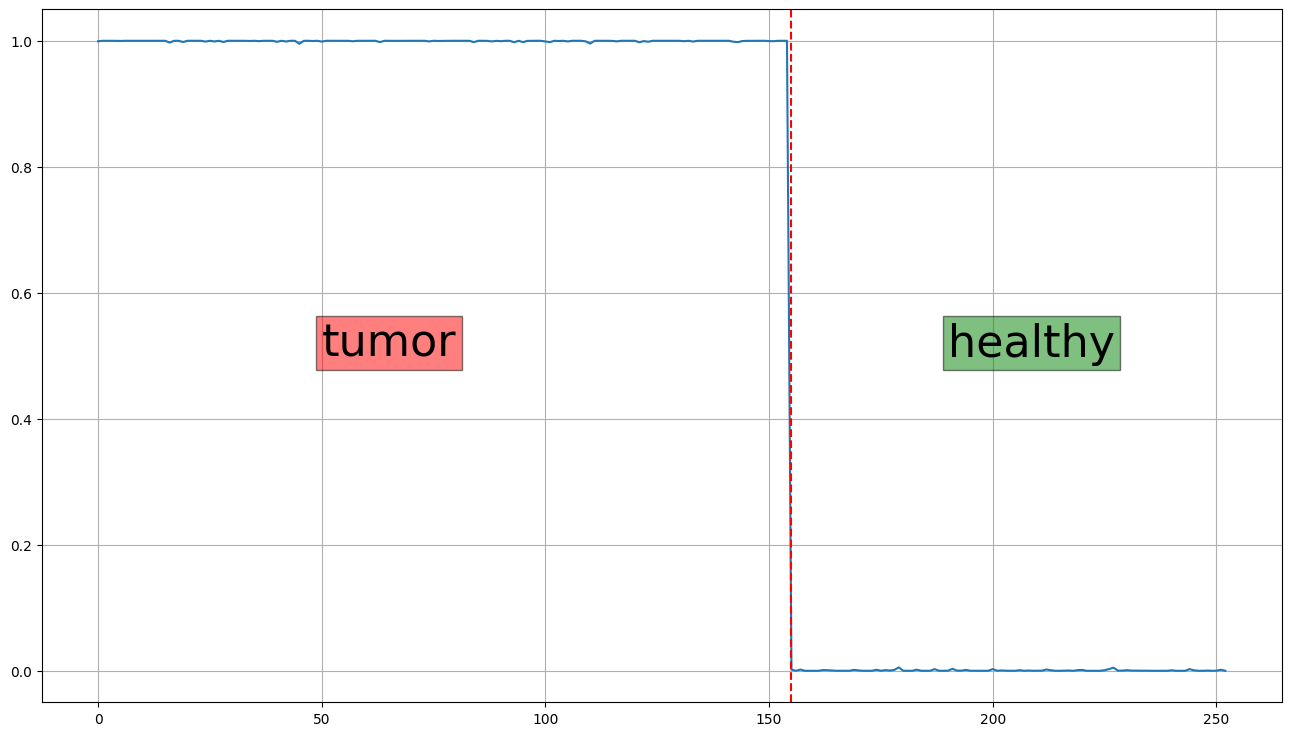

In [28]:
plt.figure(figsize=(16,9))
# plt.text(-2.5, 0.5, "tumor", fontsize=24)
plt.text(50, 0.5, "tumor", bbox=dict(facecolor='red', alpha=0.5), fontsize=32)
plt.text(190, 0.5, "healthy", bbox=dict(facecolor='green', alpha=0.5), fontsize=32)
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()